In [6]:
import os, torch
from sklearn.model_selection import train_test_split
import pickle
import torch_geometric.transforms as T
import numpy as np
from torch_geometric.nn.models import Node2Vec
from torch_geometric.data import DataLoader
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
GCNConv._orig_propagate = GCNConv.propagate

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch_geometric.explain import GNNExplainer, Explainer

model_name = 'old-womprat-13'  # Replace with your model name
# model_name = 'holographic-master-15'  # Replace with your model name
graph_num = 17 
weight_prefix = 'best_loss'
random_seed =  100
bins = [int(i) for i in "400 800 1300 2100 3000 3700 4700 7020 9660".split(' ')] 
dropout_p =  0.5
epochs = 100


bins = torch.tensor(bins, device='cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using CUDA device: {torch.cuda.get_device_name(0)}", flush = True)
else:
    device = torch.device('cpu')
    print("Using CPU", flush = True)


with open(f'../data/graphs/{graph_num}/linegraph_tg.pkl', 'rb') as f:
    data = pickle.load(f)


def stratified_split(data, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """Splits data into train, validation, and test sets, stratifying by y > 0."""

    # Create a boolean mask for nodes where y > 0
    positive_mask = data.y > 0

    # Get indices of positive and negative nodes
    positive_indices = positive_mask.nonzero(as_tuple=False).squeeze()
    negative_indices = (~positive_mask).nonzero(as_tuple=False).squeeze()

    # Split positive indices
    pos_train_idx, pos_temp_idx = train_test_split(positive_indices, train_size=train_ratio, random_state=random_seed)  # Adjust random_state for consistent splits
    pos_val_idx, pos_test_idx = train_test_split(pos_temp_idx, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=random_seed)

    # Split negative indices
    neg_train_idx, neg_temp_idx = train_test_split(negative_indices, train_size=train_ratio, random_state=random_seed)
    neg_val_idx, neg_test_idx = train_test_split(neg_temp_idx, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=random_seed)

    # Combine indices
    train_idx = torch.cat([pos_train_idx, neg_train_idx])
    val_idx = torch.cat([pos_val_idx, neg_val_idx])
    test_idx = torch.cat([pos_test_idx, neg_test_idx])

    # Create masks
    train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True

    data.train_mask = train_mask
    data.val_mask = val_mask
    data.test_mask = test_mask

    return data

data.edge_index = data.edge_index.contiguous()
data.x = data.x.contiguous()
data.y = data.y.contiguous()

print(data.x.shape, data.edge_index.shape, data.y.shape, flush = True)

data = stratified_split(data)

# --- Model Definitions ---
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_layers):
        super().__init__()
        torch.manual_seed(random_seed)

        self.input_layer = GCNConv(data.num_features, hidden_channels, improved=True, cached=True)

        # Create intermediate hidden layers (optional)
        self.hidden_layers = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.hidden_layers.append(GCNConv(hidden_channels, hidden_channels, improved=True, cached=True))

        self.output_layer = GCNConv(hidden_channels, len(bins) + 1, cached=True)

    def forward(self, x, edge_index):
        x = self.input_layer(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=dropout_p, training=self.training)

        for layer in self.hidden_layers:
            x = layer(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=dropout_p, training=self.training)

        x = self.output_layer(x, edge_index)
        return x

# Load the model with the GCN class
model = torch.load(f'../data/graphs/{graph_num}/models/{model_name}.pt', map_location=device)
model = model.to(device)

model.load_state_dict(torch.load(f'../data/graphs/{graph_num}/models/{model_name}_{weight_prefix}.pt', map_location=device))


Using CPU
torch.Size([78168, 31]) torch.Size([2, 152596]) torch.Size([78168])


<All keys matched successfully>

In [7]:
# import os
# import pickle
# from torch_geometric.explain import Explainer, GNNExplainer

# # === Parameters ===
# explainer_epochs = 50
# graph_model_path = f'../data/graphs/{graph_num}/models/{model_name}_{weight_prefix}.pt'
# explanation_output_path = f'../data/graphs/{graph_num}/explanations/{model_name}/graph_level_explanation.pkl'
# os.makedirs(os.path.dirname(explanation_output_path), exist_ok=True)


# # === Wrap in Explainer ===
# explainer = Explainer(
#     model=model,
#     algorithm=GNNExplainer(epochs=explainer_epochs).to(device),
#     explanation_type='model',
#     node_mask_type='attributes',
#     edge_mask_type=None,
#     model_config=dict(
#         mode='multiclass_classification',
#         task_level='graph',
#         return_type='log_probs',
#     ),
# )

# # === Run graph-level explanation ===
# print("🔍 Running graph-level explanation...")
# explanation = explainer(data.x.to(device), data.edge_index.to(device))

# # === Save explanation to file ===
# with open(explanation_output_path, 'wb') as f:
#     pickle.dump(explanation, f)

# print(f"✅ Graph-level explanation saved to: {explanation_output_path}")


In [8]:
# with open(explanation_output_path, 'rb') as f:
#     explanation = pickle.load(f)

# explanation.visualize_feature_importance()  # for features


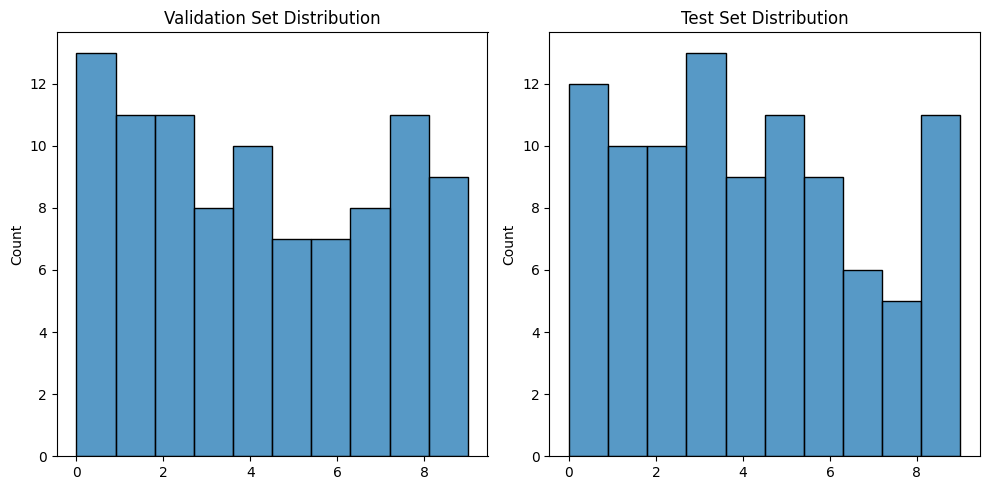

In [9]:
### visulize test y and val y

import seaborn as sns

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
mask = data.val_mask.squeeze() & (data.y > 0).squeeze()
sns.histplot(torch.bucketize(data.y[mask].squeeze(), bins).cpu().numpy(), bins=10)
plt.title('Validation Set Distribution')


plt.subplot(1, 2, 2)
mask = data.test_mask.squeeze() & (data.y > 0).squeeze()
sns.histplot(torch.bucketize(data.y[mask].squeeze(), bins).cpu().numpy(), bins=10)
plt.title('Test Set Distribution')
plt.tight_layout()
plt.show()


In [13]:
len(data.y[mask])


96